### 0. Import bibliotek

In [1]:
!pip install scikit-learn

In [81]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.4/72.0 MB 10.3 MB/s eta 0:00:07
   -- ------------------------------------- 4.7/72.0 MB 11.0 MB/s eta 0:00:07
   --- ------------------------------------ 7.1/72.0 MB 11.2 MB/s eta 0:00:06
   ----- ---------------------------------- 9.7/72.0 MB 11.4 MB/s eta 0:00:06
   ------ --------------------------------- 12.1/72.0 MB 11.4 MB/s eta 0:00:06
   -------- ------------------------------- 14.4/72.0 MB 11.5 MB/s eta 0:00:06
   --------- ------------------------------ 17.0/72.0 MB 11.5 MB/s eta 0:00:05
   ---------- ----------------------------- 19.4/72.0 MB 11.6 MB/s eta 0:00:05
   ------------ --------------------------- 21.8/72.0 MB 11.6 MB/s eta 0:00:05
   ------------- -------------------------- 24.1/72.0 MB 11.6 MB/s eta 0:00:05
   -------------- ------------------------- 26.7/72.0 MB 11.6 MB/s eta 0:0

In [ ]:
!pip install tensorflow

In [99]:
!pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 4.6 MB/s  0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------- ----- 2.4/2.8 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.4 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   -- ------------------------------------- 2.1/38.1 MB 11.7 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/38.1 MB 11.2 MB/s eta 0:00:04
   ------- -------------------------------- 6.8/38.1 MB 11.0 MB/s eta 0:00:03
   --------- ------------------------------ 9.2/38.1 MB 11.4 MB/s eta 0:00:03
   ------------ --------------------------- 11.5/38.1 MB 11.4 MB/s eta 0:00:03
   -------------- ------------------------- 13.9/38.1 MB 

In [2]:
import pandas as pd
import os
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

## 1. Praca na zbiorze

### 1.1 Zaciągnięcie danych

In [3]:
print(os.getcwd())

C:\Users\Michał J\Desktop\MJ_mgr\Codes


In [4]:
df = pd.read_csv('../Data/NPS_2025.csv', sep=';', keep_default_na=False, na_values=[''], low_memory=False) # ";" ze względu na kolumny opisowe gdzie wykorzysywano ","

In [5]:
df.head(1) #Surowy plik ma 99 kolumn, z czego dużo bezużytecznych

,Survey ID,Local Response Date,Booking ID,Customer ID,PNR,Delay (Flight 1),Delay (Flight 2),Delay Reason (Flight 1),Delay Reason (Flight 2),Booking channel,...,Space for hand luggage - F2,Temperature of the cabin - F2,Complementary accessories onboard - F2,Travel comfort comment - F2,Age of the Passenger,Purpose of trip,Purpose of Trip - Comment,Survey language,Passenger country of Residence,LOT travel frequency
0,16567668,15.12.2025 18:49,14222637,1230659547,XTD88W,0,NaN,NaN,NaN,LOT.COM,...,NaN,NaN,NaN,NaN,50 years old and more,Tourism,NaN,English,80.0,This was my first trip with LOT


In [6]:
len(df) #Surowy plik ma 88707 wierszy

88707

### 1.2 Pierwsze zmiany w danych

In [7]:
#Wyrzucam niepotrzebne kolumny z listy (konkretnie to te które uznałem za bezużyteczne)
df_ID = pd.read_csv('../Data/ID_Col.csv', sep=';')

wybrane_kolumny = df_ID[df_ID['Usability'] != 'bezużyteczna']['Name'].tolist()

# 2. Na wszelki wypadek sprawdzamy, czy te nazwy na pewno istnieją w Twoim df
# (To zapobiega błędowi KeyError)
istniejace_kolumny = [col for col in wybrane_kolumny if col in df.columns]

# 3. Zostawiamy w df tylko te kolumny
df = df[istniejace_kolumny]

# Liczba pozostałych kolumn
len(df.columns)

49

In [8]:
#Słownik mapowania nazw kolumn

col_names = {
    'Survey ID': 'ID',
    'Local Response Date': 'Response Date',
    'No. of Pax in Reservation': 'Pax on PNR',
    'LOT travel frequency': 'Airline Travel Frequency',
    'Age of the Passenger': 'Age',
    'NPS & OSAT comment': 'Comment',
    'Delay (Flight 1)': 'Delay - F1',
    'Delay (Flight 2)': 'Delay - F2',
    'Range (Flight 1)': 'Range - F1',
    'Range (Flight 2)': 'Range - F2',
    'Cabin Class (Flight 1)': 'Cabin Class - F1',
    'Cabin Class (Flight 2)': 'Cabin Class - F2',
    'Fligth 1 IFE Flag': 'IFE Flag - F1',
    'Flight 2 IFE Flag': 'IFE Flag - F2',
    'Check-in method (Declarative)': 'Check-in method',
    'Boarding at origin airport': 'Boarding',
    'Gate experience at origin airport': 'Gate experience',
    'Transfer between flights': 'Transfer',
    'In-flight entertainment - F1': 'IFE - F1',
    'In-flight entertainment - F2': 'IFE - F2',
    'Complementary accessories onboard - F1': 'Accessories - F1',
    'Complementary accessories onboard - F2': 'Accessories - F2'
}
# Zmiana nazw w głównym DataFrame
df = df.rename(columns=col_names)
# Zmiana wartości w kolumnie 'Name' w tabeli pomocniczej
df_ID['Name'] = df_ID['Name'].replace(col_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88707 entries, 0 to 88706
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ID                                88707 non-null  int64 
 1   Response Date                     88707 non-null  object
 2   Delay - F1                        87260 non-null  object
 3   Delay - F2                        35277 non-null  object
 4   Range - F1                        88707 non-null  object
 5   Range - F2                        37492 non-null  object
 6   Cabin Class - F1                  88707 non-null  object
 7   Cabin Class - F2                  37492 non-null  object
 8   M&M Flag                          88707 non-null  object
 9   Pax on PNR                        88707 non-null  object
 10  Country                           88707 non-null  object
 11  Transfer Flag                     88707 non-null  object
 12  IFE Flag - F1     

In [9]:
#Zamieniam NPS na binarną: Jeżeli NPS>7 to 0 (zadowolony) w przeciwnym wypadku 1 (niezadowolony) bo badamy niezadowolenie
# NPS > 6 to 0 (zadowolony)
# NPS <= 6 to 1 (niezadowolony)
df['NPS'] = np.where(df['NPS'] > 6, 0, 1)
df['NPS'].value_counts()

NPS
0    75175
1    13532
Name: count, dtype: int64

In [10]:
# Klasy są trochę niezbalansowane (stosunek ok. 4:1), na szczęście nasz zbiór jest duży (~88 tysięcy rekordów).
# Mimo to, przy tworzeniu modeli zastosujemy:

# A) Dla drzew i lasów
#parametr wagowy (class_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Ustawienie 'balanced' sprawia, że biblioteka automatycznie doważa rzadszą klasę.

# B) do XGBoosta
# parametr wagowy (scale_pos_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Dla XGBoost wartość tę wyliczamy ręcznie jako stosunek liczby pasażerów zadowolonych do niezadowolonych.

# C) do sieci neuronowej
# mechanizm wagowania klas (class_weight), aby model traktował priorytetowo poprawną klasyfikację grupy niezadowolonej (klasa 1).
# Wagi te (przekazane do metody .fit) zwiększą karę (loss) za błędy popełnione na rzadszej klasie.

### Obsługa braków danych wynikająca z braku danego pytania

In [11]:
#W zbiorze występują dwa typy braków danych: Nan oraz N/A, w zależności od zmiennej musimy inaczej je potraktować

# 1. Liczymy dosłowne teksty "N/A"
na_text_counts = (df == "N/A").sum()

# 2. Liczymy techniczne blanki (NaN / None)
blank_counts = df.isna().sum()

# 3. Łączymy to w jedną czytelną tabelę
missing_table = pd.DataFrame({
    'Tekstowe "N/A"': na_text_counts,
    'Techniczne Blanki': blank_counts
})
missing_table

,"Tekstowe ""N/A""",Techniczne Blanki
ID,0,0
Response Date,0,0
Delay - F1,0,1447
Delay - F2,0,53430
Range - F1,0,0
Range - F2,0,51215
Cabin Class - F1,0,0
Cabin Class - F2,0,51215
M&M Flag,0,0
Pax on PNR,0,0


In [12]:
# Kolumna Delay - F1, jeżeli brak danych to znaczy że samolot się nie spóźnił
df['Delay - F1'] = df['Delay - F1'].fillna(0)

In [13]:
#Zamiana Transfer Flag na binarą
df['Transfer Flag'] = df['Transfer Flag'].map({'Yes': 1, 'No': 0})
print(df['Transfer Flag'].value_counts())

Transfer Flag
0    51215
1    37492
Name: count, dtype: int64


In [14]:
# Zmienne Delay mają za dużo kategorii -  w tym celu łączę je w 3: nieopóźniony, lekko opóźniony i bardzo opóźniony
# Według standardów IATA i Eurocontrol, lot uznaje się za "punktualny", jeśli wystartuje lub wyląduje do 15 minut po planowanym czasie.
# Zakres do 1 godziny pozwala wyłonić loty, które mają problem operacyjny, ale mieszczą się w tzw. "buforze" czasowym większości lotnisk
# Przekroczenie 60 minut to w lotnictwie poważne zakłócenie. Granica > 180 min (3 godziny) jest szczególnie istotna w Unii Europejskiej 
# ze względu na rozporządzenie WE 261/2004, które od tego momentu często daje pasażerom prawo do odszkodowania pieniężnego.

delay_mapping = {
    # Nie opóźniony
    '0': 'Nie opóźniony',
    '1-15 min': 'Nie opóźniony',
    
    # Lekko opóźniony
    '16-30 min': 'Lekko opóźniony',
    '31-45 min': 'Lekko opóźniony',
    '46-60 min': 'Lekko opóźniony',
    
    # Bardzo opóźniony
    '61-120 min': 'Bardzo opóźniony',
    '121- 180 min': 'Bardzo opóźniony', # Uwaga: na obrazku widać spację po myślniku
    '> 180 min': 'Bardzo opóźniony'
}


cols_to_fix = ['Delay - F1', 'Delay - F2']

for col in cols_to_fix:
    # Opcjonalnie: .str.strip() usuwa ewentualne ukryte spacje na początku/końcu
    df[col] = df[col].str.strip().map(delay_mapping)

In [15]:
# Kolumna Delay - F1, jeżeli brak danych to znaczy że samolot się nie spóźnił
df.loc[(df['Delay - F1'].isna()), 'Delay - F1'] = 'Nie opóźniony'

In [16]:
#Kolumna Delay -F2, jeżeli brak danych a Transfer Flag 1 to samolot się nie spóźnił, w przeciwnym wypadku nie było 2 lotu i przypisz -999
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 1), 'Delay - F2'] = 'Nie opóźniony'
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 0), 'Delay - F2'] = -999

In [17]:
#Kolumny Range - F2 i Cabin Class - F2, przypisujemy -999 kiedy transfer flag = 0
df.loc[(df['Range - F2'].isna()) & (df['Transfer Flag'] == 0), 'Range - F2'] = -999
df.loc[(df['Cabin Class - F2'].isna()) & (df['Transfer Flag'] == 0), 'Cabin Class - F2'] = -999

In [18]:
#Kolumna M&M Flag nie ma braków, ale zamieniam ją na binarną
df['M&M Flag'] = df['M&M Flag'].map({'Yes': 1, 'No': 0})
print(df['M&M Flag'].value_counts())

M&M Flag
0    74980
1    13727
Name: count, dtype: int64


In [19]:
# Flagujemy grupy większe równe 4 osób, nie jest to oficjalna grupa, ponieważ taka zaczyna się od 10 pasażerów, jednak w danych chciałem wyłapać
# Czy podróżowanie w więcej osób wpływa na satysfakcję
df['Group Flag'] = df['Pax on PNR'].isin(['4', '5+']).astype(int)
# Usuwamy starą kolumnę
df = df.drop(columns='Pax on PNR')
# Sprawdzamy nowe statystyki
print(df['Group Flag'].value_counts())

Group Flag
0    84176
1     4531
Name: count, dtype: int64


In [20]:
# Kolumna Comment ma kilka tekstowych "N/A", zmieniam to na NaN
df['Comment'] = df['Comment'].replace('N/A', np.nan)
# Ta kolumna nie będzie użyta w modelu, ale posłuży do analizy sentymentu

In [21]:
#Kolumna Check-in jest popsuta, NaN nie powinny wystąpić, narazie zostawiam bez zmian, docelowo zmieniam N/A na NaN

In [22]:
#Kolumny Boarding, Security check, Gate experience - zmieniam N/A na NaN
cols_to_fix = ['Boarding', 'Security check', 'Gate experience']
for col in cols_to_fix:
    
    df[col] = pd.to_numeric(df[col], errors='coerce') # zmienienie na float samo przekonwertuje N/A na NaN

In [23]:
#Agregacja kolumn dotyczących business lounge, zakładam że ci którzy nie wypełnili ankiety nie mieli okazji skorzystać z Lounge
lounge_cols = ['Business Lounge at WAW (Warsaw)', 'Business Lounge at ORD (Chicago)']
for col in lounge_cols:
    
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Pandas obsłuży to tak: [5, NaN] -> 5.0 | [4, 6] -> 5.0 | [NaN, NaN] -> NaN
df['Business Lounge'] = df[lounge_cols].mean(axis=1)

df = df.drop(columns=lounge_cols)

# Wynik: 1 = Pax był w BL (jest ocena), 0 = Paxa nie było w BL (brak oceny)
df['BL Flag'] = df['Business Lounge'].notna().astype(int)

# Zastępujemy puste miejsca (NaN) wartością -999
df['Business Lounge'] = df['Business Lounge'].fillna(-999)

In [24]:
# Osoby, które nie miały transferu przypisuję -999, pozostali poprostu nie odpowiedzieli
df.loc[(df['Transfer Flag'] == 0), 'Transfer'] = -999
# W następnej kolejności zmieniam N/A na nan i konwertuje na float
df['Transfer'] = pd.to_numeric(df['Transfer'], errors='coerce')

In [25]:
#Zmienna Baggage Claim - bardzo dużo braków, ze względu na to że wielu pasażerów nie nadaje bagażu, niestety z danych nie wynika, którzy pasażerowie
# nie nadawali a którzy nie odpowiedzieli przypisuje wiec wszystkim brakom -999
df['Baggage claim'] = pd.to_numeric(df['Baggage claim'], errors='coerce')
# Tworzenie flagi
# Wynik: 1 = Bagaż był (jest ocena), 0 = Brak bagażu (brak oceny)
df['Baggage Flag'] = df['Baggage claim'].notna().astype(int)
#Przypisuję -999
df.loc[df['Baggage claim'].isna(), 'Baggage claim'] = -999

In [26]:
#Zamiana IFE Flags na binarną
df['IFE Flag - F1'] = df['IFE Flag - F1'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F1'].value_counts())
df['IFE Flag - F2'] = df['IFE Flag - F2'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F2'].value_counts())

IFE Flag - F1
0    77150
1    11557
Name: count, dtype: int64
IFE Flag - F2
0    83307
1     5400
Name: count, dtype: int64


In [27]:
# Zmienne dotyczące IFE, jeżeli pax nie miał dostępu (flaga 0) to przypisz -999
df.loc[df['IFE Flag - F1'] == 0, 'IFE - F1'] = -999
df['IFE - F1'] = pd.to_numeric(df['IFE - F1'], errors='coerce')
df.loc[df['IFE Flag - F2'] == 0, 'IFE - F2'] = -999
df['IFE - F2'] = pd.to_numeric(df['IFE - F2'], errors='coerce')

In [28]:
print(df['Accessories - F1'].value_counts())

Accessories - F1
5      1907
4       605
3       199
N/A      54
2        50
1        39
Name: count, dtype: int64


In [29]:
#Zajmujemy siękolumną dotyczącą akcesoriów, mamy bardzo dużo braków, wynika to głównie z faktu że tylko Premium i Biznes dostają te rzeczy
import pandas as pd
import numpy as np

analysis_df = df.copy()

# pomocnicze kolumny logizzne
analysis_df['Is_Blank'] = analysis_df['Accessories - F1'].isna()
analysis_df['Is_NA_Text'] = analysis_df['Accessories - F1'] == 'N/A'
analysis_df['Has_Rating'] = pd.to_numeric(analysis_df['Accessories - F1'], errors='coerce').notna()

# Tabelka z missingami
missing_report = analysis_df.groupby('Cabin Class - F1').agg({
    'Is_Blank': 'sum',      # Suma fizycznych pustych pól
    'Is_NA_Text': 'sum',    # Suma wpisów tekstowych "N/A"
    'Has_Rating': 'sum'     # Ile osób wystawiło ocenę
})

# % Udział ocen
missing_report['Completeness_%'] = (missing_report['Has_Rating'] / 
                                    (missing_report['Is_Blank'] + missing_report['Is_NA_Text'] + missing_report['Has_Rating']) * 100).round(2)

print(missing_report)
#podsumowując potwierdziło się że economy tego nie dostaje, więc przypisuję im -999, premium ma wysoki poziom 

                  Is_Blank  Is_NA_Text  Has_Rating  Completeness_%
Cabin Class - F1                                                  
C                     3152          22        1266           28.51
P                      100          32        1534           92.08
Y                    82601           0           0            0.00


In [30]:
# Sprawdzamy hipotezę: Akcesoria = Klasa (C/P) + Zasięg (LH)
range_check = df.groupby(['Cabin Class - F1', 'Range - F1']).agg({
    'Accessories - F1': lambda x: pd.to_numeric(x, errors='coerce').notna().mean() * 100
}).round(2)

range_check.columns = ['% wypełnionych ocen']
print("Procent wystawionych ocen w zależności od klasy i zasięgu:")
print(range_check)
#To pokazuje nam że akcesoria dostaje się jedynie na LH nie w economy

Procent wystawionych ocen w zależności od klasy i zasięgu:
                             % wypełnionych ocen
Cabin Class - F1 Range - F1                     
C                DOM                        0.00
                 LH                        97.53
                 SH                         0.00
P                LH                        97.40
                 SH                         0.00
Y                DOM                        0.00
                 LH                         0.00
                 SH                         0.00


In [31]:
# Lista par kolumn do przetworzenia
flights = [
    {'score': 'Accessories - F1', 'class': 'Cabin Class - F1', 'range': 'Range - F1'},
    {'score': 'Accessories - F2', 'class': 'Cabin Class - F2', 'range': 'Range - F2'}
]

for f in flights:
    #  Konwersja na liczby
    df[f['score']] = pd.to_numeric(df[f['score']], errors='coerce')
    
    # Definicja braku usługi:
    # True = Usługa NIE przysługiwała (Strukturalny brak)
    mask_no_service = (df[f['range']] != 'LH') | (df[f['class']] == 'Y')

    # TWORZENIE FLAGI "Brak ..."
    flag_name =  f['score'] + ' Flag'
    
    # Przypisanie: 1 jeśli usługi brakowało, 0 jeśli przysługiwała
    df[flag_name] = (~mask_no_service).astype(int)

    # 4. Przypisanie -999
    df.loc[mask_no_service, f['score']] = -999

In [32]:
#Pozbywamy się N/A dla kolumn F1 i przekszatałcamy na numeric te pytania (oprócz IFE i Akcesoriów, ale to jest obsługiwane osobno)
# z założenia dostali wszyscy pasażerowie
cols_f1 = [col for col in df.columns if 'F1' in col]
#tych nie chce zmieniać
exceptions = ['Delay - F1', 'Range - F1', 'IFE Flag - F1','Cabin Class - F1']

cols_to_convert = [col for col in cols_f1 if col not in exceptions]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [33]:
#Dla F2 bedzie podobnie, jednak najpierw trzeba oznaczyć te rekordy które mają Transfer Flag 0 przypisując -999
cols_f2 = [col for col in df.columns if 'F2' in col]

exceptions_f2 = ['Delay - F2', 'Range - F2', 'IFE Flag - F2','Cabin Class - F2','Accessories - F2 Flag']

cols_to_convert_f2 = [col for col in cols_f2 if col not in exceptions_f2]

#  paxbez transferu (Flag 0) otrzymują -999
for col in cols_to_convert_f2:
    df.loc[df['Transfer Flag'] == 0, col] = -999

#Pozostali pasażerowie mieli transfer, czyli nie odpowiedzieli poprostu na pytania, w takim przypadku oznaczamy ich jako blank poprzez konwersje typu
# konwersja na numeric
for col in cols_to_convert_f2:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [34]:
#Jeżeli mamy blank w wieku to oznaczam jako nie chcę podawać
df.loc[df['Age'].isna(), 'Age'] = "I prefer not to say" 

In [35]:
print(df['Airline Travel Frequency'].value_counts(dropna=False, normalize=True))

Airline Travel Frequency
Once, several times a year         0.506499
This was my first trip with LOT    0.401344
At least once a month              0.079430
NaN                                0.012727
Name: proportion, dtype: float64


In [36]:
#NaN jest około 1.2% w całości, nie wiem co kryje się pod tymi brakami, ale mogą one nieść za sobą istotną informację, 
# z tego powodu tworzę nową kategorię
col_cat = 'Airline Travel Frequency'
# Wypełniamy w obu zbiorach
df[col_cat] = df[col_cat].fillna('Unknown')

In [37]:
### Sprawdzam czy pozbyłem się wszystkich N/A

na_text_counts = (df == "N/A").sum()

blank_counts = df.isna().sum()

missing_table = pd.DataFrame({
    'Tekstowe "N/A"': na_text_counts,
    'Prawdziwe braki': blank_counts
})
missing_table

,"Tekstowe ""N/A""",Prawdziwe braki
ID,0,0
Response Date,0,0
Delay - F1,0,0
Delay - F2,0,0
Range - F1,0,0
Range - F2,0,0
Cabin Class - F1,0,0
Cabin Class - F2,0,0
M&M Flag,0,0
Country,0,0


In [38]:
# Sprawdzam jaki typ braków mam w zmiennych zbioru
from scipy.stats import pointbiserialr

def analyze_all_missing_impact(df, target_col):
    results = []
    
    # Tylko te rzędy gdzie nasz target nie jest brakiem (u nas nigdzie nie jest)
    df_clean = df.dropna(subset=[target_col]).copy()
    
    # Iterujemy po wszystkich kolumnach poza targetem
    for col in df_clean.columns:
        if col == target_col:
            continue
            
        # Sprawdzamy czy w ogóle są jakieś braki w tej kolumnie
        null_count = df_clean[col].isnull().sum()
        
        if null_count > 0:
            # Tworzymy flagę braku (1-brak, 0-jest)
            missing_flag = df_clean[col].isnull().astype(int)
            
            # Mierzy związek między zmienną binarną (brak/jest) a ciągłą (NPS)
            corr, p_val = pointbiserialr(missing_flag, df_clean[target_col])
            
            results.append({
                'Zmienna': col,
                'Typ danych': str(df_clean[col].dtype),
                'Korelacja z NPS': round(corr, 4),
                'p-value': round(p_val, 4),
            })
    
    res_df = pd.DataFrame(results)
    if not res_df.empty:
        return res_df.sort_values(by='Korelacja z NPS')
    else:
        return "Brak kolumn z brakami danych do analizy."

In [39]:
raport_brakow = analyze_all_missing_impact(df, 'NPS')
print(raport_brakow)

                          Zmienna Typ danych  Korelacja z NPS  p-value
0                         Comment     object          -0.2390   0.0000
15               Accessories - F1    float64           0.0097   0.0039
9                        IFE - F1    float64           0.0105   0.0018
1                        Check-in     object           0.0140   0.0000
25               Accessories - F2    float64           0.0161   0.0000
20                       IFE - F2    float64           0.0178   0.0000
5                        Transfer    float64           0.0376   0.0000
3                  Security check    float64           0.0528   0.0000
8            Food & Beverage - F1    float64           0.0588   0.0000
18           Food & Beverage - F2    float64           0.0605   0.0000
22                  Leg room - F2    float64           0.0625   0.0000
4                 Gate experience    float64           0.0669   0.0000
12                  Leg room - F1    float64           0.0684   0.0000
23    

In [40]:
# Weryfikacja mechanizmu braków danych (Uzasadnienie k-NN) 

# Przeprowadzone testy statystyczne wykazały korelację między występowaniem braku odpowiedzi a zmienną celu (NPS) z p-value < 0.05:

# 1. Wynik ten jest efektem "pułapki dużej próby" (N > 80 000), gdzie nawet pomijalne różnice stają się istotne statystycznie.

# 2. Zależność braku danych od obserwowalnych zmiennych wskazuje na mechanizm 
#   MAR (Missing At Random), a nie MNAR. Oznacza to, że brak informacji można wyjaśnić innymi cechami dostępnymi w zbiorze.

# 3. Powyższe uzasadnia użycie algorytmu k-NN, który skutecznie rekonstruuje wartości 
#   w warunkach MAR, dobierając sąsiadów o zbliżonym profilu niezadowolenia.

### Obsługa braków pytania dla sieci neuronowej

In [41]:
# Powyższy kod powoduje, że oddzielamy braki wynikające z braku pytania (przypisując im -999, co będzie omijane przez model) od braków "prawdziwych"
# wynikających z braku odpowiedzi na pytanie. Przypisywanie -999 działa dobrze dla modeliopartych na drzewach, te modele ominą te wartości
# jednak sieć neuronowa nie obsłuży ich poprawnie, w tym celu duplikuję zbiór. Aby uzyskać efekt w którym brak danych jest "przezroczysty" dla sieci
# wykonuję trzy kroki 1) Tworzę zmiene binarne (już zrobione) 2) uśredniam wartość dla braków numerycznych (skala 1-5), natomiast do zmiennych kat
# przy one hot encodingu usunięte zostaną powstałe zmienne -999

In [42]:
df_tree = df.copy() # Tutaj zostają -999
df_nn = df.copy()   # Tutaj "czyszczę" -999

In [43]:
# df_tree jest gotowe na kolejny etap, 
# natomiast w df_nn musimy pozbyć się -999. W tym celu dla wszystkich zmiennych numerycznych zamienieam -999 na średnia

# tylko kolumny numeryczne
numeric_cols = df_nn.select_dtypes(include=[np.number]).columns

x = 0
for col in numeric_cols:
    # Sprawdzamy, czy w kolumnie w ogóle występuje -999
    if (df_nn[col] == -999).any():
        
        # Obliczam średnią dla każdej zmienej
        # Warunek: wartość nie jest -999 ORAZ wartość nie jest NaN (prawdziwy brak)
        valid_values = df_nn.loc[(df_nn[col] != -999) & (df_nn[col].notna()), col]
        
        if len(valid_values) > 0:
            clean_mean = valid_values.mean()
            
            # zmiana -999 na wyliczoną średnią
            df_nn.loc[df_nn[col] == -999, col] = clean_mean
            
            x += 1

In [44]:
# Teraz obsłużyłem braki danych wynikające z braku pytania osobno dla modeli opartych na drzewach i tych opartych na sieciach neuronowych
#Następnie zajmę się imputacją tych drugich, jednak aby uniknąć data lickage najpierw podzielę zbiór trenignowy, walidacyjny i testowy
# Ważnne aby ustawić random_state aby oba typy modeli pracowały na tych samych id rekordów

### Imputacja "prawdziwych" braków

In [45]:
### Sprawdzenie czy oba zbiory maja tyle samo blanków

# 1. Liczymy dosłowne teksty "N/A"
na_text_counts_tree = (df_tree == "N/A").sum()
na_text_counts_nn = (df_nn == "N/A").sum()
# 2. Liczymy techniczne blanki (NaN / None)
blank_counts_tree = df_tree.isna().sum()
blank_counts_nn = df_nn.isna().sum()
# 3. Łączymy to w jedną czytelną tabelę
missing_table = pd.DataFrame({
    'Tekstowe "N/A tree': na_text_counts_tree,
    'Prawdziwe braki tree': blank_counts_tree,
    'Tekstowe "N/A nn"': na_text_counts_nn,
    'Prawdziwe braki nn': blank_counts_nn
})
missing_table

,"Tekstowe ""N/A tree",Prawdziwe braki tree,"Tekstowe ""N/A nn""",Prawdziwe braki nn
ID,0,0,0,0
Response Date,0,0,0,0
Delay - F1,0,0,0,0
Delay - F2,0,0,0,0
Range - F1,0,0,0,0
Range - F2,0,0,0,0
Cabin Class - F1,0,0,0,0
Cabin Class - F2,0,0,0,0
M&M Flag,0,0,0,0
Country,0,0,0,0


In [46]:
# Lista zmiennych objaśniających (X)
# NPS to zmienna celu
selected_features = [
    # Dane o locie
    'Range - F1', 'Range - F2', 'Cabin Class - F1', 'Cabin Class - F2', 'Delay - F1', 'Delay - F2',
    # Flagi
    'M&M Flag', 'Transfer Flag', 'IFE Flag - F1', 'IFE Flag - F2', 
    'Group Flag', 'Baggage Flag', 'Accessories - F1 Flag', 'Accessories - F2 Flag', 'BL Flag',
    # Usługi ogólne
    'Boarding', 'Security check', 'Gate experience', 'Transfer', 'Baggage claim', 'Business Lounge',
    # Lot 1
    'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 'IFE - F1', 
    'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 
    'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1',
    # Lot 2
    'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 'Cleanliness - F2', 
    'IFE - F2', 'Your seat - F2', 'Leg room - F2', 
    'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2',
    # Pozostałe
    'Purpose of trip', 'Airline Travel Frequency'
]

target_col = 'NPS'

# Filtrowanie df
X_tree = df_tree[selected_features].copy()
X_nn = df_nn[selected_features].copy()

# Zmienna celu jest taka sama dla obu
# Na razie wyciągamy surowy NPS.
y = df_tree[target_col].copy()

In [47]:
# Aby zastosować metodę kNN, gdzie algorytm musi porównać ich cechy muszę zamienić wszystkie zmienne do typu numerycznego, nawet kategorialne
# po to aby służyły jako punkt odniesienia do imputowania zmiennych numerycznych
cat_cols_to_encode = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2'
]
#konwertuję kolumny kategorialne na string (występują w nich wartości -999 i to wyrzucało błąd)
X_tree[cat_cols_to_encode] = X_tree[cat_cols_to_encode].astype(str)
X_nn[cat_cols_to_encode] = X_nn[cat_cols_to_encode].astype(str)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Kodujemy w obu zbiorach (zamiana napisów na liczby 0, 1, 2...)
X_tree[cat_cols_to_encode] = encoder.fit_transform(X_tree[cat_cols_to_encode])
X_nn[cat_cols_to_encode] = encoder.fit_transform(X_nn[cat_cols_to_encode])


In [48]:
#Teraz dzielę na zbiory treningowy, walidacyjny i testowy w proporcji Train (70%) / Val (15%) / Test (15%)
# WYdzielam testowy
X_work_tree, X_test_tree, y_work, y_test = train_test_split(
    X_tree, y, test_size=0.15, random_state=42, stratify=y
)
X_work_nn, X_test_nn, y_work_nn, y_test_nn = train_test_split(
    X_nn, y, test_size=0.15, random_state=42, stratify=y
)

# Wydzielam walidacyjny
# 0.15 / 0.85 = ~0.1765
val_size_adjusted = 0.15 / 0.85 

X_train_tree, X_val_tree, y_train, y_val = train_test_split(
    X_work_tree, y_work, test_size=val_size_adjusted, random_state=42, stratify=y_work
)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_work_nn, y_work_nn, test_size=val_size_adjusted, random_state=42, stratify=y_work_nn
)

print(f"Rozmiar Train: {X_train_tree.shape[0]}")

Rozmiar Train: 62094


In [49]:
print(f"Rozmiar Train: {X_test_nn.shape[0]}")

Rozmiar Train: 13307


In [50]:
#Zdecydowałem się pozostawić wartości ciągłe generowane przez k-NN, ponieważ ich zaokrąglanie do mediany wiązałoby się z utratą informacji,
#nie wnosząc jednocześnie żadnej wartości dodanej z perspektywy głównego celu pracy.
#W kontekście identyfikacji czynników wpływających na niezadowolenie (analiza SHAP), różnica techniczna między wartością np. 3.6 a 4.0 jest pomijalna 
#– model i tak prawidłowo zinterpretuje wagę danej cechy, dlatego uznałem dodatkowe przekształcenia za zbędne.

In [51]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from tqdm.auto import tqdm 

#Imputacja kNN

with tqdm(total=6, desc="Przygotowanie", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:

    # dla zbioru dla drzew z -999
    pbar.set_description("Imputacja: Train (Drzewa)")
    imputer_tree = KNNImputer(n_neighbors=5)
    X_train_tree_imputed = pd.DataFrame(
        imputer_tree.fit_transform(X_train_tree), 
        columns=X_train_tree.columns, index=X_train_tree.index
    )
    pbar.update(1)

    pbar.set_description("Imputacja: Val (Drzewa)")
    X_val_tree_imputed = pd.DataFrame(
        imputer_tree.transform(X_val_tree), 
        columns=X_val_tree.columns, index=X_val_tree.index
    )
    pbar.update(1)

    pbar.set_description("Imputacja: Test (Drzewa)")
    X_test_tree_imputed = pd.DataFrame(
        imputer_tree.transform(X_test_tree), 
        columns=X_test_tree.columns, index=X_test_tree.index
    )
    pbar.update(1)

    # dla zbioru sieci neuronowej
    pbar.set_description("Imputacja: Train (Sieci)")
    imputer_nn = KNNImputer(n_neighbors=5)
    
    X_train_nn_imputed = pd.DataFrame(
        imputer_nn.fit_transform(X_train_nn), 
        columns=X_train_nn.columns, index=X_train_nn.index
    )
    pbar.update(1)

    pbar.set_description("Imputacja: Val (Sieci)")
    X_val_nn_imputed = pd.DataFrame(
        imputer_nn.transform(X_val_nn), 
        columns=X_val_nn.columns, index=X_val_nn.index
    )
    pbar.update(1)

    pbar.set_description("Imputacja: Test (Sieci)")
    X_test_nn_imputed = pd.DataFrame(
        imputer_nn.transform(X_test_nn), 
        columns=X_test_nn.columns, index=X_test_nn.index
    )
    pbar.update(1)

print("\nImputacja zakończona. Przechodzę do czyszczenia błędów...")

#Podczas szybkiej imputacji kNN (gdzie `-999` traknowano jako liczbę) algorytm w rzadkich przypadkach dobierał do pasażera z ocenami (np. 5.0) 
#sąsiada z brakiem strukturalnym (`-999`). 
# Efektem było powstanie tzw. "zatrutych średnich" (np. `-196.6`), które nie są ani poprawną oceną, ani kodem braku.
# Ze względu na marginalną skalę błędu (zaledwie 0.02% danych), zastosowano korektę 
# Błędne wartości ujemne zastąpiono średnią dla danej zmiennej (z wartości dodatnich)
# Próbowałem zrobić poprawkę w trakcie kNN jednak działało to bardzo wolno, stąd uproszczenie
# Logika: Każda wartość, która jest mniejsza od 0, ale większa od -900, 
# jest "zatruta" średnią z -999. Zamieniamy ją na średnią z dodatnich ocen w tej kolumnie.

def fix_poisoned_values(df):
    df_clean = df.copy()
    counter = 0
    
    # Tylko kolumny numeryczne
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        # Szukamy zatrutych wartości: (Wartość < 0) oraz (Wartość > -900)
        # Czyli np. -196, -300, -798. Ale kod nie dotyka -999
        poisoned_mask = (df_clean[col] < 0) & (df_clean[col] > -900)
        
        if poisoned_mask.any():
            # Liczba znalezionych błędów
            n_errors = poisoned_mask.sum()
            
            # Obliczam średnią dla tej kolumny (bierzemy tylko wartości dodatnie > 0)
            valid_mean = df_clean.loc[df_clean[col] > 0, col].mean()
            
            # Nadpisujemy zatrute wartości
            df_clean.loc[poisoned_mask, col] = valid_mean
            
            counter += n_errors
            
    return df_clean, counter

# apliakcja poprawki
X_train_tree_imputed, c1 = fix_poisoned_values(X_train_tree_imputed)
X_val_tree_imputed, c2 = fix_poisoned_values(X_val_tree_imputed)
X_test_tree_imputed, c3 = fix_poisoned_values(X_test_tree_imputed)

print(f"\n Naprawiono łącznie {c1 + c2 + c3} zatrutych wartości.")

Przygotowanie:   0%|          | 0/6 [00:00<?]


Imputacja zakończona. Przechodzę do czyszczenia błędów...

 Naprawiono łącznie 537 zatrutych wartości.


In [52]:
print(f"Rozmiar Train: {X_test_nn_imputed.shape[0]}")

Rozmiar Train: 13307


In [53]:
# Sumowanie braków 
blank_counts_train_tree = X_train_tree_imputed.isna().sum()
blank_counts_val_tree = X_val_tree_imputed.isna().sum()
blank_counts_test_tree = X_test_tree_imputed.isna().sum()

blank_counts_train_nn = X_train_nn_imputed.isna().sum()
blank_counts_val_nn = X_val_nn_imputed.isna().sum()
blank_counts_test_nn = X_test_nn_imputed.isna().sum()

# Zestawienie wszystkiego w jednej tabeli
missing_table = pd.DataFrame({
    'Tree Train': blank_counts_train_tree,
    'Tree Val':   blank_counts_val_tree,
    'Tree Test':  blank_counts_test_tree,
    'NN Train':   blank_counts_train_nn,
    'NN Val':     blank_counts_val_nn,
    'NN Test':    blank_counts_test_nn
})

missing_table

,Tree Train,Tree Val,Tree Test,NN Train,NN Val,NN Test
Range - F1,0,0,0,0,0,0
Range - F2,0,0,0,0,0,0
Cabin Class - F1,0,0,0,0,0,0
Cabin Class - F2,0,0,0,0,0,0
Delay - F1,0,0,0,0,0,0
Delay - F2,0,0,0,0,0,0
M&M Flag,0,0,0,0,0,0
Transfer Flag,0,0,0,0,0,0
IFE Flag - F1,0,0,0,0,0,0
IFE Flag - F2,0,0,0,0,0,0


In [54]:
X_train_nn_imputed['Cabin Class - F2'].value_counts()

Cabin Class - F2
0.0    35908
3.0    24351
1.0     1344
2.0      491
Name: count, dtype: int64

In [55]:
X_train_tree_imputed['Baggage claim'].value_counts()

Baggage claim
-999.0    25351
 5.0      24275
 4.0       6359
 1.0       2662
 3.0       2369
 2.0       1078
Name: count, dtype: int64

In [101]:
X_train_tree_imputed['Baggage claim'].value_counts()

Baggage claim
-999.0    25351
 5.0      24275
 4.0       6359
 1.0       2662
 3.0       2369
 2.0       1078
Name: count, dtype: int64

In [57]:
X_train_nn_imputed['Delay - F2'].value_counts()

Delay - F2
0.0    35908
3.0    20701
2.0     4878
1.0      607
Name: count, dtype: int64

### One hot encoding

In [58]:
# Pozbyliśmy się braków z sukcesem, jednak OrdinalEncoder zmienił nam kategorie na liczby, co było potrzebne do kNN, ale teraz jest trochę mylące
# encoder jednak zapamiętał mapowanie
# Sprawdzamy, co oznaczają liczby w kolumnach kategorialnych
# encoder.categories_ to lista, gdzie każda lista odpowiada jednej kolumnie

encoded_columns = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2'
    
]

for i, col_name in enumerate(encoded_columns):

    original_names = encoder.categories_[i]
    
    print(f"Zmienna: {col_name}")
    for value, name in enumerate(original_names):
        # value to 0, 1, 2... (to co widzi model)
        # name to "Economy", "Business" itd
        print(f"  {float(value)} = '{name}'")
    print("-" * 30)

Zmienna: Range - F1
  0.0 = 'DOM'
  1.0 = 'LH'
  2.0 = 'SH'
------------------------------
Zmienna: Range - F2
  0.0 = '-999'
  1.0 = 'DOM'
  2.0 = 'LH'
  3.0 = 'SH'
------------------------------
Zmienna: Cabin Class - F1
  0.0 = 'C'
  1.0 = 'P'
  2.0 = 'Y'
------------------------------
Zmienna: Cabin Class - F2
  0.0 = '-999'
  1.0 = 'C'
  2.0 = 'P'
  3.0 = 'Y'
------------------------------
Zmienna: Purpose of trip
  0.0 = 'Other (please specify):'
  1.0 = 'Tourism'
  2.0 = 'Visiting family or friends'
  3.0 = 'Work related'
------------------------------
Zmienna: Airline Travel Frequency
  0.0 = 'At least once a month'
  1.0 = 'Once, several times a year'
  2.0 = 'This was my first trip with LOT'
  3.0 = 'Unknown'
------------------------------
Zmienna: Delay - F1
  0.0 = 'Bardzo opóźniony'
  1.0 = 'Lekko opóźniony'
  2.0 = 'Nie opóźniony'
------------------------------
Zmienna: Delay - F2
  0.0 = '-999'
  1.0 = 'Bardzo opóźniony'
  2.0 = 'Lekko opóźniony'
  3.0 = 'Nie opóźniony'


In [59]:
import pandas as pd
import numpy as np

encoded_columns = [
    'Range - F1', 'Range - F2', 
    'Cabin Class - F1', 'Cabin Class - F2', 
    'Purpose of trip', 'Airline Travel Frequency',
    'Delay - F1', 'Delay - F2' 
]

# 2. Funckcja która przetworzy tak każdy nasz zbiór (mamy ich 6)
def process_encoding(df_input, encoder, columns_list):
    
    df = df_input.copy()

    #Dla sprawdzenia czy nic sie nie popsuło - wielkość zbiorów
    print(f"Wymiar zbioru: {df.shape}...")
    
    # Przywracanie nazw
    for i, col_name in enumerate(columns_list):
        if col_name not in df.columns:
            continue # Pomijamy, jeśli kolumny nie ma
            
        # Pobieram kategorie z encodera
        categories = encoder.categories_[i]
        
        # mapowanie
        mapping_dict = {}
        for index, label in enumerate(categories):
            label_str = str(label)
            
            # Zamieniam kategorie -999 na No_Flight - jeżeli wykryje -999 to zamień na No_Flight
            if '-999' in label_str: 
                new_label = 'No_Flight'
            else:
                new_label = label_str
                
            mapping_dict[index] = new_label
            
        # Aplikujemy mapowanie
        # fillna zabezpiecza nas, gdyby coś nie pasowało
        df[col_name] = df[col_name].map(mapping_dict).fillna(df[col_name])

    # One hot encoding
    df_encoded = pd.get_dummies(df, columns=columns_list, prefix=columns_list, drop_first=False)
    
    # Usuwanie dummies z No_flight w nazwie - brak drugiego lotu jest już flagowany w kolumnie Transfer Flag
    cols_to_drop = [c for c in df_encoded.columns if 'F2' in c and 'No_Flight' in c]
    
    if cols_to_drop:
        print(f"  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): {cols_to_drop}")
        df_encoded = df_encoded.drop(columns=cols_to_drop)
    
    return df_encoded

# teraz odpalam funkcje na każdym zbiorze

X_train_tree_final = process_encoding(X_train_tree_imputed, encoder, encoded_columns)
X_val_tree_final   = process_encoding(X_val_tree_imputed, encoder, encoded_columns)
X_test_tree_final  = process_encoding(X_test_tree_imputed, encoder, encoded_columns)


X_train_nn_final   = process_encoding(X_train_nn_imputed, encoder, encoded_columns)
X_val_nn_final     = process_encoding(X_val_nn_imputed, encoder, encoded_columns)
X_test_nn_final    = process_encoding(X_test_nn_imputed, encoder, encoded_columns)


# Sprawdzamy czy liczba kolumn się zgadza we wszystkich zbiorach (musi być identyczna!)
print(f"Tree Train: {X_train_tree_final.shape}")
print(f"Tree Val:   {X_val_tree_final.shape}")
print(f"Tree Test:  {X_test_tree_final.shape}")
print("-" * 20)
print(f"NN Train:   {X_train_nn_final.shape}")
print(f"NN Val:     {X_val_nn_final.shape}")
print(f"NN Test:    {X_test_nn_final.shape}")


# Sprawdzenie czy usunęliśmy No_Flight dla F2
bad_cols = [c for c in X_train_tree_final.columns if 'Delay - F2_No_Flight' in c]
if not bad_cols:
    print("Sukces: Usunięto nadmiarowe kolumny 'No_Flight' dla F2.")
else:
    print(f"BŁĄD: Nadal istnieją kolumny: {bad_cols}")

Wymiar zbioru: (62094, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Wymiar zbioru: (13306, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Wymiar zbioru: (13307, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Wymiar zbioru: (62094, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Wymiar zbioru: (13306, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Class - F2_No_Flight', 'Delay - F2_No_Flight']
Wymiar zbioru: (13307, 43)...
  -> Usuwam nadmiarowe kolumny (zastąpione przez Transfer Flag): ['Range - F2_No_Flight', 'Cabin Cla

In [60]:
X_train_tree_final['Delay - F1_Lekko opóźniony'].value_counts()

Delay - F1_Lekko opóźniony
False    52046
True     10048
Name: count, dtype: int64

### Korelacja - usuwanie zmiennych ze sobą skorelowanych

In [61]:
#Wyliczenia korelacji. Jako że na zbiorze nn uzupełniłem -999 średnią to patrzę na zbiór trees już po imputacji (tymczasowo zmieniając -999 na NaN.
# Biorę więc zbiór treningowy tree i sklejam go czasowo z NPS

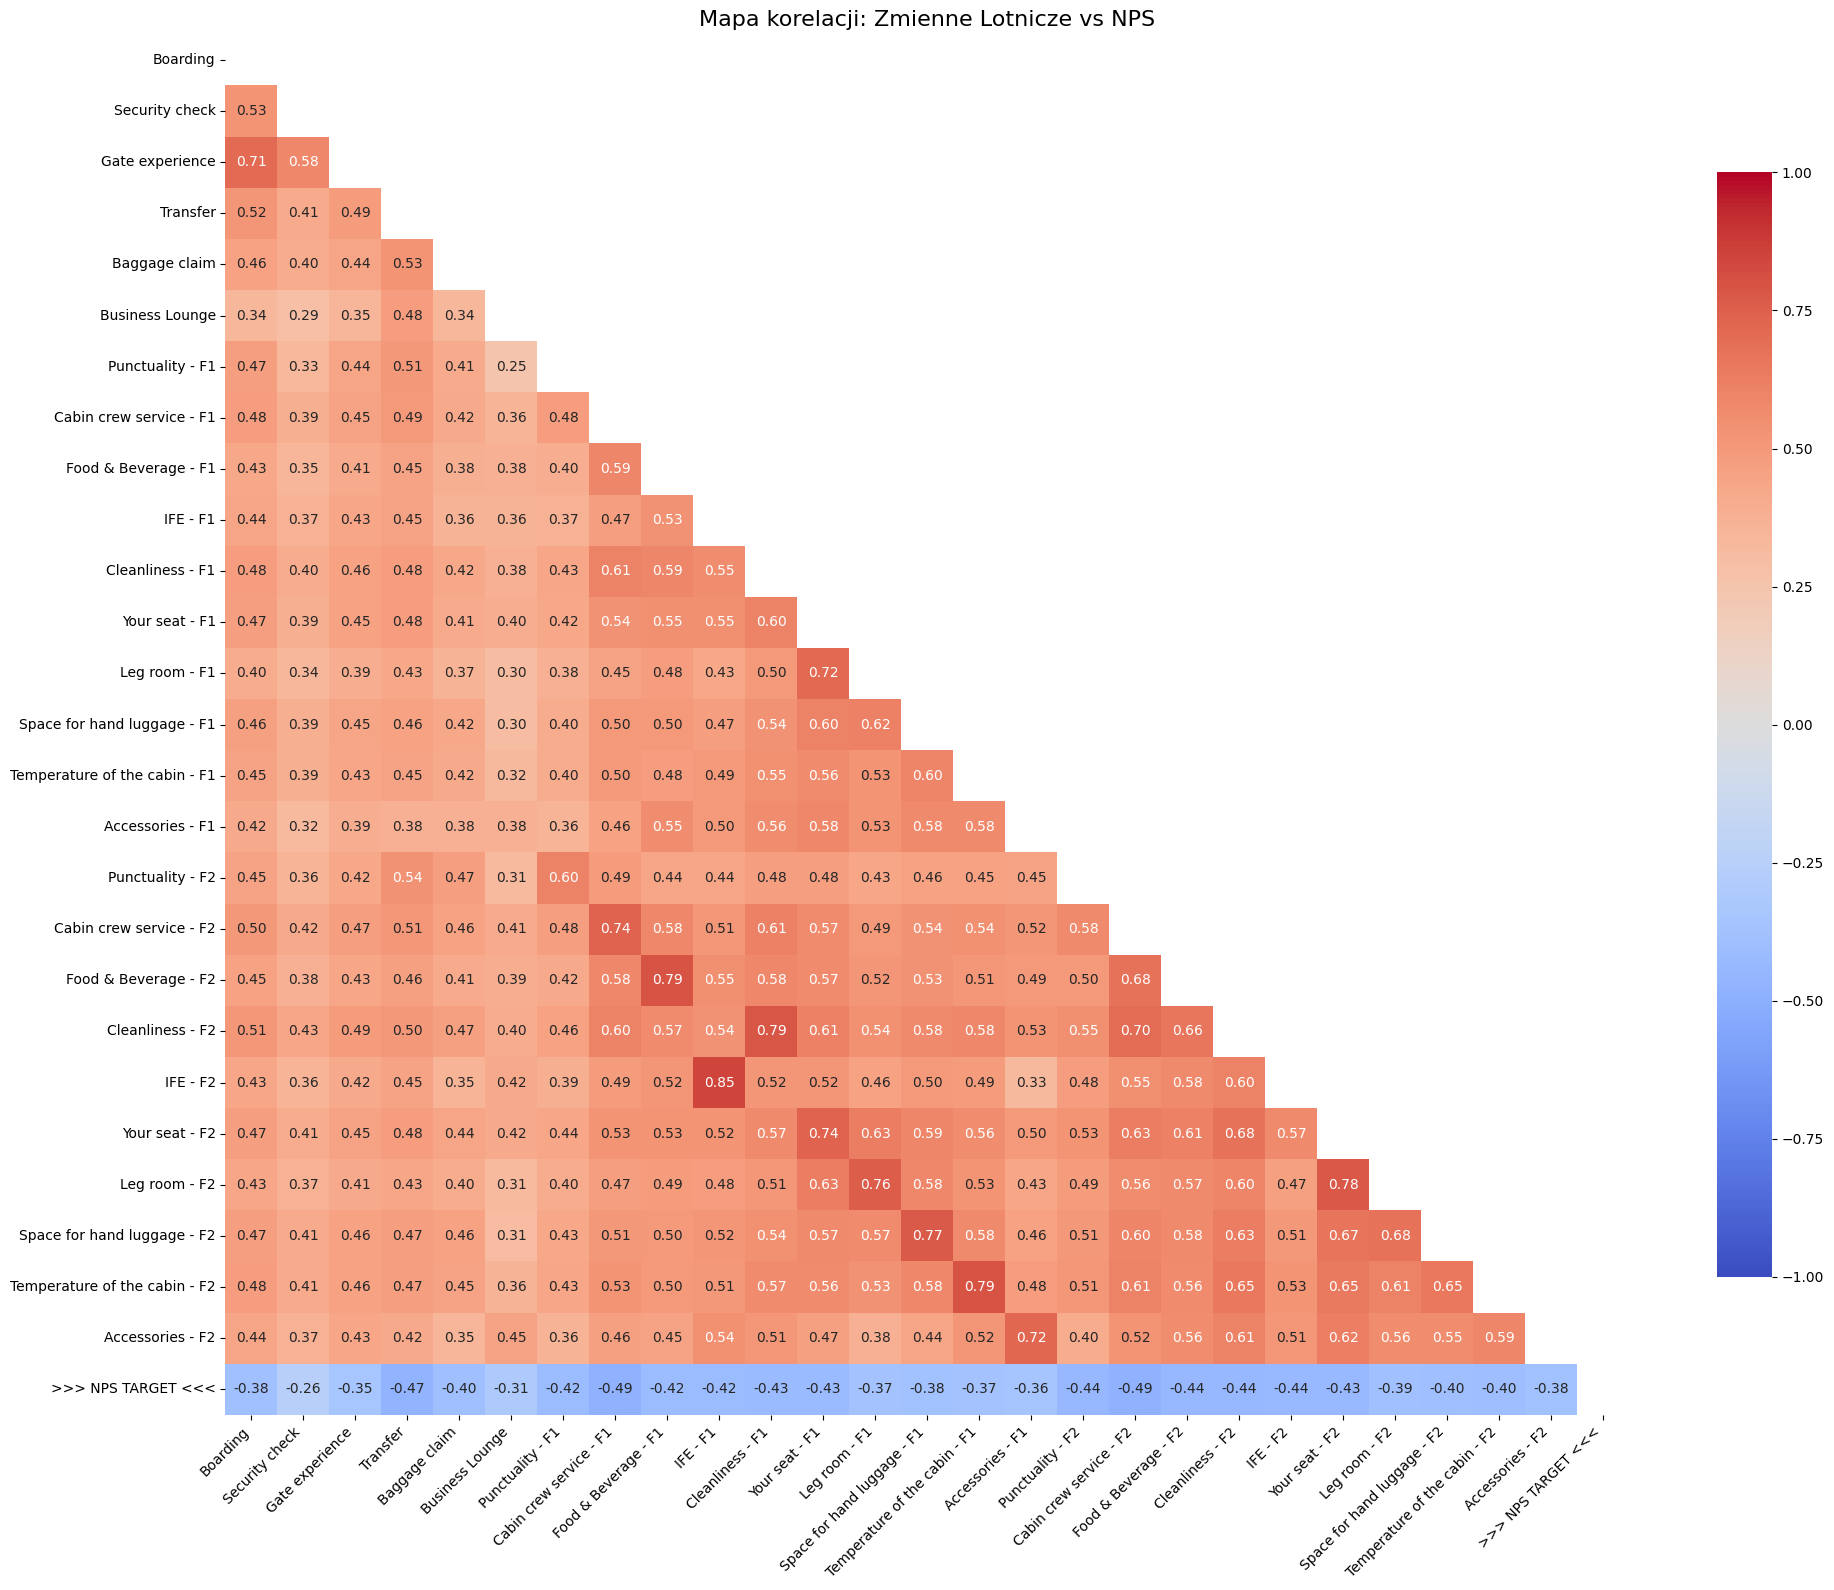

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

selected_columns = [
    'Boarding', 'Security check', 'Gate experience', 'Transfer', 
    'Baggage claim', 'Business Lounge',
    'Punctuality - F1', 'Cabin crew service - F1', 'Food & Beverage - F1', 
    'IFE - F1', 'Cleanliness - F1', 'Your seat - F1', 'Leg room - F1', 
    'Space for hand luggage - F1', 'Temperature of the cabin - F1', 'Accessories - F1',
    'Punctuality - F2', 'Cabin crew service - F2', 'Food & Beverage - F2', 
    'Cleanliness - F2', 'IFE - F2', 'Your seat - F2', 'Leg room - F2', 
    'Space for hand luggage - F2', 'Temperature of the cabin - F2', 'Accessories - F2'
]

df_analysis = X_train_tree_final.copy()
# Dodaję NPS czyli zmienną celu
df_analysis = df_analysis[selected_columns]
df_analysis['>>> NPS TARGET <<<'] = y_train
# encoder zakodował -999 jako 0 dla wybranych kolumn kategorialnych, umieszczam je tu
f2_cols_with_zero_as_missing = [
    'Cabin Class - F2', 'Delay - F2', 'Range - F2'
]
# Zmieniam tylko na powyższych kolumnach
for col in f2_cols_with_zero_as_missing:
    if col in df_analysis.columns:
        df_analysis[col] = df_analysis[col].replace(0, np.nan)
# Do wyliczenia korelacji czasowo pozbywam się -999        
df_analysis = df_analysis.replace(-999, np.nan)

# Korelacja Spearmana
corr_matrix = df_analysis.corr(method='spearman')

plt.figure(figsize=(20, 16))
# Używamy maski, żeby pokazać tylko dolny trójkąt (czytelniej)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='coolwarm', 
            annot=True,     # w liczbowe
            fmt=".2f",      # 2 miejsca po przecinku
            vmin=-1, vmax=1, # Skala od 0 do 1
            cbar_kws={"shrink": .8})

plt.title("Mapa korelacji: Zmienne Lotnicze vs NPS", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

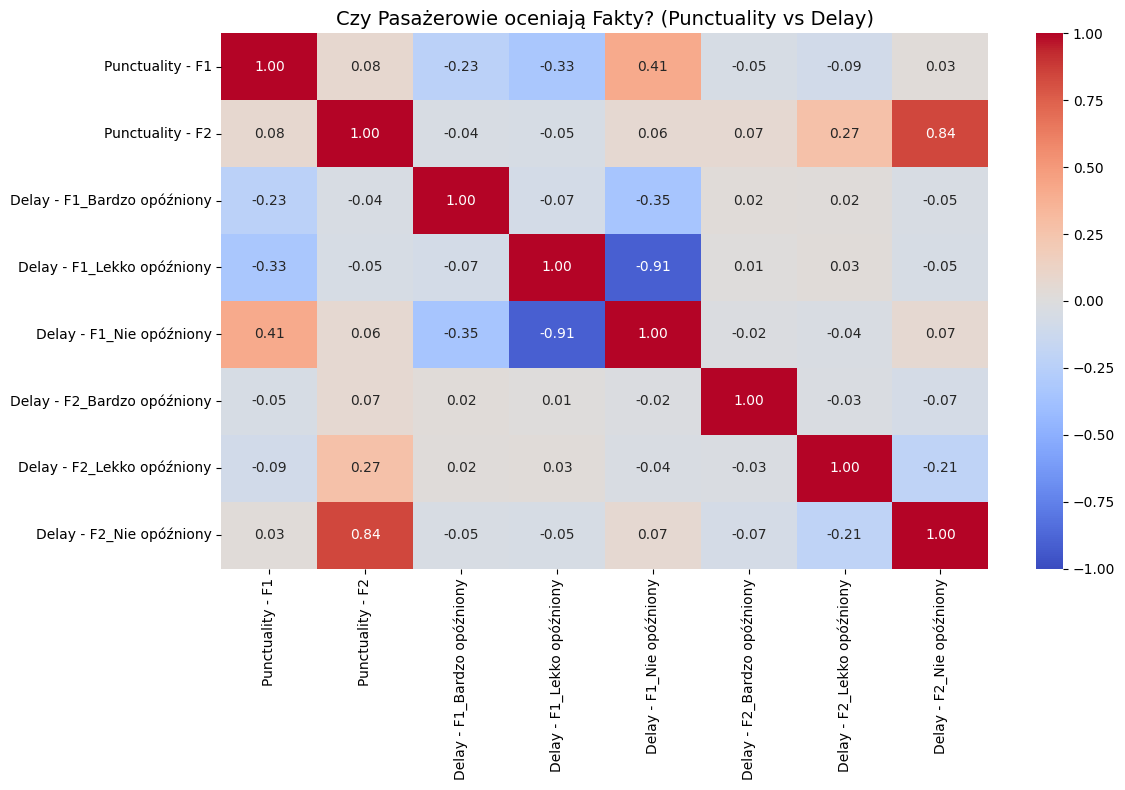

In [63]:
#Sprawdzam czy zmienna punctality jest silnie skorelowana z dummies mówiącymi o prawdziwym opóźnieniu samolotu
import seaborn as sns
import matplotlib.pyplot as plt

# Szukamy wszystkiego co ma w nazwie "Punctuality" LUB "Delay"
focus_cols = [col for col in X_train_tree_final.columns if 'Punctuality' in col or 'Delay' in col]

# 2. Tworzymy mniejszą macierz korelacji
subset_corr = X_train_tree_final[focus_cols].corr(method='spearman')

# 3. Rysujemy czytelną heatmapę
plt.figure(figsize=(12, 8))
sns.heatmap(subset_corr, 
            annot=True,       # Pokaż liczby
            cmap='coolwarm',  # Kolory: Czerwony (mocna dodatnia), Niebieski (mocna ujemna)
            fmt=".2f", 
            vmin=-1, vmax=1)  # Pełna skala od -1 do 1

plt.title("Czy Pasażerowie oceniają Fakty? (Punctuality vs Delay)", fontsize=14)
plt.tight_layout()
plt.show()
#Poniższa heatmapa wyjaśjnia że delay i punctuality nie są ze sobą silnie skorelowane, co może być trochę nielogiczne, ale 
# pasażerowie nie oceniają punktualności "z automatu" na podstawie zegarka. tutaj role gra też dobra komunikacja oraz obsługa tych nieregularności.
# W drugą strone samolot na przykłąd abrdzo długo kołował co technicznie opóźnieniem nie jest a pax uznał że punktualność słaba
# lekkie opóźnienia mają niższy współczynnik niż duże - to wynika z nierównowagi klas. Tych drugich jest poprostu znacznie mniej

In [64]:
# Macierz korelacji wskazuje na bardzo wysoką korelację między zmienną Gate experience a Boarding, dlatego zdecydowałem się usunąć pierwsząz nich
# Ponadto wiele zmiennych dotyczących tego samego elementu, ale na dwóch lotach ma wysoką korelacje, wynika to z faktu że często pasażer zaznacza 
# wysoką bądź niską notę na obu lotach tak samo. Jeżeli jest korelacja między tymi dwoma zmiennymi to nie będę ich usuwał
# Drugą zmienną do usunięcia jest leg room która jest wysoce skorelowana z your seat.
# Lista zmiennych do usunięcia na podstawie analizy korelacji
cols_to_drop = [
    'Gate experience', 
    'Leg room - F1', 
    'Leg room - F2'
]

# usuwam z każdego zbioru
X_train_tree_final = X_train_tree_final.drop(columns=cols_to_drop, errors='ignore')
X_val_tree_final = X_val_tree_final.drop(columns=cols_to_drop, errors='ignore')
X_test_tree_final = X_test_tree_final.drop(columns=cols_to_drop, errors='ignore')

# to samo dla zbiorów dla sieci neuronowej
X_train_nn_final = X_train_nn_final.drop(columns=cols_to_drop, errors='ignore')
X_val_nn_final = X_val_nn_final.drop(columns=cols_to_drop, errors='ignore')
X_test_nn_final = X_test_nn_final.drop(columns=cols_to_drop, errors='ignore')


In [65]:
X_train_tree_final

,M&M Flag,Transfer Flag,IFE Flag - F1,IFE Flag - F2,Group Flag,Baggage Flag,Accessories - F1 Flag,Accessories - F2 Flag,BL Flag,Boarding,...,Airline Travel Frequency_At least once a month,"Airline Travel Frequency_Once, several times a year",Airline Travel Frequency_This was my first trip with LOT,Airline Travel Frequency_Unknown,Delay - F1_Bardzo opóźniony,Delay - F1_Lekko opóźniony,Delay - F1_Nie opóźniony,Delay - F2_Bardzo opóźniony,Delay - F2_Lekko opóźniony,Delay - F2_Nie opóźniony
28628,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,False,False,True,False,False,True,False,False,True,False
85079,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,False,True,False,False,False,False,True,False,False,False
6293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,False,True,False,False,False,True,False,False,False,False
5845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,False,True,False,False,False,False,True,False,False,False
73014,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76408,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,False,True,False,False,False,False,True,False,False,True
41306,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,False,False,True,False,False,False,True,False,True,False
83882,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,False,True,False,False,False,False,True,False,False,True
49268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.6,...,False,True,False,False,False,False,True,False,False,False


# Modele

## Modele drzewiaste

### Drzewa

In [75]:
# Trzy warianty modeli drzew
# W każdym używam balanced, cosprawia, że biblioteka automatycznie doważa rzadszą klasę.
# To też implikuje nam niższą precyzję, model częściej oznaczy kogoś niezadowolonego aby nie przeoczyć nikogo, dlatego jest duży recall
# Bez zbalansowania klas cechy, które są kluczowe dla "niezadowolonych" zostaną stłumione przez cechy typowe dla "zadowolonych" (większości)
models_trees = {
    "Model 1: Swobodny": DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42
        # Brak ograniczeń głębokości - ryzyko overfittingu
    ),
    
    "Model 2: Płytki": DecisionTreeClassifier(
        class_weight='balanced', 
        max_depth=4,            # Bardzo krótkie drzewo
        min_samples_leaf=50,    # Musi być dużo ludzi w grupie, żeby podjąć decyzję
        random_state=42
    ),
    
    "Model 3: Środkowy": DecisionTreeClassifier(
        class_weight='balanced', 
        max_depth=8,            # Średnia głębokość
        min_samples_leaf=20,    # Zabezpieczenie przed pojedynczymi przypadkami
        min_samples_split=50,
        random_state=42
    )
}

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Zmienne do śledzenia lidera
best_model_name = ""
best_model_obj = None
best_val_auc = 0

print(f"{'='*20} ETAP 1: TRENING I WALIDACJA (Szukanie modelu) {'='*20}")

# Pętla trenująca i oceniająca
for name, model in models_trees.items():
    print(f"\n--- {name} ---")
    
    # 1. Trenowanie (na X_train)
    model.fit(X_train_tree_final, y_train)
    
    # 2. Predykcja (na Train i WALIDACJI)
    # Zmieniliśmy X_test na X_val, żeby nie spalić testu!
    y_pred_train = model.predict(X_train_tree_final)
    y_pred_val = model.predict(X_val_tree_final)
    y_prob_val = model.predict_proba(X_val_tree_final)[:, 1]
    
    # 3. Metryki (Szukanie Overfittingu)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego modelu na podstawie AUC na walidacji
    if auc_val > best_val_auc:
        best_val_auc = auc_val
        best_model_obj = model
        best_model_name = name

# --- ETAP KOŃCOWY ---

print(f"\n\n{'='*20} ETAP 2: OSTATECZNY SPRAWDZIAN (Sąd Ostateczny) {'='*20}")
print(f"Zwycięzcą został: {best_model_name}")
print("Sprawdzamy go teraz na ukrytym zbiorze TESTOWYM (X_test)...")

y_pred_final = best_model_obj.predict(X_test_tree_final)
y_prob_final = best_model_obj.predict_proba(X_test_tree_final)[:, 1]

final_acc = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_prob_final)
final_report = classification_report(y_test, y_pred_final)

print(f"\n=== WYNIKI KOŃCOWE (Do raportu) ===")
print(f"Final Accuracy: {final_acc:.2%}")
print(f"Final ROC-AUC:  {final_auc:.4f}")
print("\nPełny raport klasyfikacji:")
print(final_report)

==================== ETAP 1: TRENING I WALIDACJA (Szukanie modelu) ====================

--- Model 1: Swobodny ---
Accuracy Train: 99.48%
Accuracy Val:   87.23%
ROC-AUC Val:    0.7312

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 57.39%
Precision:        58.28%

--- Model 2: Płytki ---
Accuracy Train: 81.90%
Accuracy Val:   81.82%
ROC-AUC Val:    0.8791

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 81.03%
Precision:        44.71%

--- Model 3: Środkowy ---
Accuracy Train: 84.18%
Accuracy Val:   83.91%
ROC-AUC Val:    0.9132

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 84.29%
Precision:        48.43%


==================== ETAP 2: OSTATECZNY SPRAWDZIAN (Sąd Ostateczny) ====================
Zwycięzcą został: Model 3: Środkowy
Sprawdzamy go teraz na ukrytym zbiorze TESTOWYM (X_test)...

=== WYNIKI KOŃCOWE (Do raportu) ===
Final Accuracy: 83.47%
Final ROC-AUC:  0.9082

Pełny raport kla

### Lasy Losowe

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Definiujemy 3 warianty Lasów Losowych
models_rf = {
    "RF Model 1: Swobodny": RandomForestClassifier(
        n_estimators=200,       # 200 drzew
        class_weight='balanced', 
        max_depth=None,         # Drzewa mogą rosnąć jak chcą
        n_jobs=-1,              # Użyj wszystkich rdzeni procesora (szybkość!)
        random_state=42
    ),
    
    "RF Model 2: Konserwatywny": RandomForestClassifier(
        n_estimators=100,       # Mniej drzew wystarczy przy prostym modelu
        class_weight='balanced', 
        max_depth=6,            # Bardzo płytkie drzewa (tylko główne reguły)
        min_samples_leaf=50,    # Duże grupy w liściach
        n_jobs=-1,
        random_state=42
    ),
    
    "RF Model 3: Środkowy": RandomForestClassifier(
        n_estimators=300,       # Więcej drzew = stabilniejszy wynik (ale dłużej się liczy)
        class_weight='balanced_subsample', # Wersja precyzyjniejsza wag dla lasów
        max_depth=12,           # Rozsądna głębokość
        min_samples_leaf=10,    # Balans między szczegółem a ogółem
        max_features='sqrt',    # Standard dla klasyfikacji
        n_jobs=-1,
        random_state=42
    )
}

In [84]:
# Zmienne do śledzenia lidera w kategorii Lasów
best_rf_name = ""
best_rf_obj = None
best_rf_val_auc = 0

print(f"{'='*20} WALIDACJA LASÓW LOSOWYCH {'='*20}")

for name, model in models_rf.items():
    print(f"\n--- {name} ---")
    
    # 1. Trenowanie (na X_train)
    # To potrwa chwilę dłużej niż pojedyncze drzewo!
    model.fit(X_train_tree_final, y_train)
    
    # 2. Predykcja (na Train i WALIDACJI)
    y_pred_train = model.predict(X_train_tree_final)
    y_pred_val = model.predict(X_val_tree_final)
    y_prob_val = model.predict_proba(X_val_tree_final)[:, 1]
    
    # 3. Metryki
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego Lasu
    if auc_val > best_rf_val_auc:
        best_rf_val_auc = auc_val
        best_rf_obj = model
        best_rf_name = name

print(f"\n\n{'='*20} SĄD OSTATECZNY (X_test) - LASY LOSOWE {'='*20}")
print(f"Zwycięzca kategorii Random Forest: {best_rf_name}")

# Predykcja zwycięskim lasem na zbiorze testowym
y_pred_final_rf = best_rf_obj.predict(X_test_tree_final)
y_prob_final_rf = best_rf_obj.predict_proba(X_test_tree_final)[:, 1]

final_acc_rf = accuracy_score(y_test, y_pred_final_rf)
final_auc_rf = roc_auc_score(y_test, y_prob_final_rf)

print(f"\n=== WYNIKI KOŃCOWE RANDOM FOREST ===")
print(f"Final Accuracy: {final_acc_rf:.2%}")
print(f"Final ROC-AUC:  {final_auc_rf:.4f}")
print("\nPełny raport:")
print(classification_report(y_test, y_pred_final_rf))


==================== WALIDACJA LASÓW LOSOWYCH ====================

--- RF Model 1: Swobodny (Głęboki) ---
Accuracy Train: 99.61%
Accuracy Val:   91.46%
ROC-AUC Val:    0.9326

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 57.83%
Precision:        80.74%

--- RF Model 2: Konserwatywny (Płytki) ---
Accuracy Train: 85.11%
Accuracy Val:   85.20%
ROC-AUC Val:    0.9187

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 82.46%
Precision:        50.93%

--- RF Model 3: Wypośrodkowany ---
Accuracy Train: 88.96%
Accuracy Val:   88.05%
ROC-AUC Val:    0.9343

Raport dla klasy 1 (Niezadowoleni) [na zbiorze walidacyjnym]:
Recall (Czułość): 83.40%
Precision:        57.47%


==================== SĄD OSTATECZNY (X_test) - LASY LOSOWE ====================
Zwycięzca kategorii Random Forest: RF Model 3: Wypośrodkowany

=== WYNIKI KOŃCOWE RANDOM FOREST ===
Final Accuracy: 87.84%
Final ROC-AUC:  0.9317

Pełny raport:
              precision 

### XGBOOST

In [82]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# --- KROK 0: Dynamiczne obliczenie wagi (scale_pos_weight) ---
# Liczymy to TYLKO na zbiorze treningowym, żeby nie było wycieku danych!
num_neg = (y_train == 0).sum()  # Zadowoleni
num_pos = (y_train == 1).sum()  # Niezadowoleni (df['NPS'] == 1)

scale_weight = num_neg / num_pos
print(f"Obliczony scale_pos_weight: {scale_weight:.4f}")
print(f"(Na każdego niezadowolonego przypada około {scale_weight:.2f} zadowolonych)\n")

# --- KROK 1: Definicja Modeli XGBoost ---

models_xgb = {
    "XGB 1: Swobodny": XGBClassifier(
        n_estimators=500,       # Dużo drzew
        max_depth=12,           # Bardzo głębokie drzewa (ryzyko overfittingu)
        learning_rate=0.3,      # Szybka nauka
        scale_pos_weight=scale_weight,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ),
    
    "XGB 2: Płytki": XGBClassifier(
        n_estimators=100,
        max_depth=3,            # Bardzo płytkie (tylko główne reguły)
        learning_rate=0.05,     # Powolna, ostrożna nauka
        scale_pos_weight=scale_weight,
        reg_lambda=10,          # Silna regularyzacja L2 (zapobiega przeuczeniu)
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ),
    
    "XGB 3: Środkowy": XGBClassifier(
        n_estimators=300,
        max_depth=6,            # Standardowa głębokość
        learning_rate=0.1,      # Złoty środek
        scale_pos_weight=scale_weight,
        subsample=0.8,          # Używaj 80% danych dla każdego drzewa (zapobiega overfittingowi)
        colsample_bytree=0.8,   # Używaj 80% cech dla każdego drzewa
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )
}

Obliczony scale_pos_weight: 5.5555
(Na każdego niezadowolonego przypada 5.56 zadowolonych)



In [83]:
# --- KROK 2: Trening i Walidacja ---

best_xgb_name = ""
best_xgb_obj = None
best_xgb_val_auc = 0

print(f"{'='*20} WALIDACJA XGBOOST {'='*20}")

for name, model in models_xgb.items():
    print(f"\n--- {name} ---")
    
    # 1. Trenowanie
    model.fit(X_train_tree_final, y_train)
    
    # 2. Predykcja (Train vs Val)
    y_pred_train = model.predict(X_train_tree_final)
    y_pred_val = model.predict(X_val_tree_final)
    y_prob_val = model.predict_proba(X_val_tree_final)[:, 1]
    
    # 3. Metryki
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}  <-- (Różnica >10% oznacza przeuczenie)")
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [na walidacji]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall (Czułość): {report['1']['recall']:.2%}")
    print(f"Precision:        {report['1']['precision']:.2%}")

    # Wybór najlepszego XGBoosta
    if auc_val > best_xgb_val_auc:
        best_xgb_val_auc = auc_val
        best_xgb_obj = model
        best_xgb_name = name

# --- KROK 3: Ostateczny Test ---

print(f"\n\n{'='*20} SĄD OSTATECZNY (X_test) {'='*20}")
print(f"Zwycięzca kategorii XGBoost: {best_xgb_name}")

y_pred_final = best_xgb_obj.predict(X_test_tree_final)
y_prob_final = best_xgb_obj.predict_proba(X_test_tree_final)[:, 1]

final_acc = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_prob_final)

print(f"\n=== WYNIKI KOŃCOWE XGBOOST ===")
print(f"Final Accuracy: {final_acc:.2%}")
print(f"Final ROC-AUC:  {final_auc:.4f}")
print("\nPełny raport:")
print(classification_report(y_test, y_pred_final))

==================== WALIDACJA XGBOOST ====================

--- XGB 1: Swobodny ---
Accuracy Train: 99.51%
Accuracy Val:   90.97%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Val:    0.8918

Raport dla klasy 1 (Niezadowoleni) [na walidacji]:
Recall (Czułość): 69.31%
Precision:        70.85%

--- XGB 2: Płytki ---
Accuracy Train: 87.46%
Accuracy Val:   87.86%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Val:    0.9311

Raport dla klasy 1 (Niezadowoleni) [na walidacji]:
Recall (Czułość): 82.71%
Precision:        57.05%

--- XGB 3: Środkowy ---
Accuracy Train: 92.59%
Accuracy Val:   90.24%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Val:    0.9419

Raport dla klasy 1 (Niezadowoleni) [na walidacji]:
Recall (Czułość): 84.04%
Precision:        63.63%


==================== SĄD OSTATECZNY (X_test) ====================
Zwycięzca kategorii XGBoost: XGB 3: Środkowy

=== WYNIKI KOŃCOWE XGBOOST ===
Final Accuracy: 89.74%
Final ROC-AUC:  0.9340

Pełny raport:
              precision    r

## Sieci neuronowe

In [92]:
import os
import random
import numpy as np
import tensorflow as tf
def reset_seeds(seed_value=42):
    # 1. Losowość systemowa/Pythona
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    
    # 2. Losowość Numpy (operacje na macierzach)
    np.random.seed(seed_value)
    
    # 3. Losowość TensorFlow (wagi sieci)
    tf.random.set_seed(seed_value)

# Wywołaj to RAZ na początku skryptu
reset_seeds()

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# 1. SKALOWANIE (Kluczowe dla sieci!)
# Nawet jeśli robiłeś imputację, musimy sprowadzić wszystko do wspólnego mianownika
scaler = StandardScaler()
X_train_nn_scaled = scaler.fit_transform(X_train_nn_final) # Uczymy skaler na treningu
X_val_nn_scaled = scaler.transform(X_val_nn_final)         # Aplikujemy na walidacji
X_test_nn_scaled = scaler.transform(X_test_nn_final)       # Aplikujemy na teście

# 2. WAGI KLAS (Dla sieci definiujemy to słownikiem)
# 0 = Zadowoleni, 1 = Niezadowoleni
# Wzór: waga = n_samples / (n_classes * n_samples_j)
total = len(y_train)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

weight_for_0 = (1 / neg) * (total / 2.0) # 2 bo mamy 2 klasy
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Wagi dla sieci: Klasa 0: {weight_for_0:.2f}, Klasa 1: {weight_for_1:.2f}")
print(f"Liczba cech wejściowych: {X_train_nn_scaled.shape[1]}")

Wagi dla sieci: Klasa 0: 0.59, Klasa 1: 3.28
Liczba cech wejściowych: 58


In [96]:
def build_nn_model(model_type, input_dim):
    model = Sequential()
    
    if model_type == "Głęboka":
        # Dużo warstw, dużo neuronów, brak Dropoutu
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid')) # Wyjście binarne
        
    elif model_type == "Płytka":
        # Mała sieć z dużą regularyzacją (Dropout)
        model.add(Dense(32, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.5)) # Wyłącza 50% neuronów losowo (zapobiega zakuwaniu)
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        
    elif model_type == "Środkowa":
        # Złoty środek
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['AUC']) # Śledzimy AUC w trakcie nauki
    return model

model_names = ["Głęboka", "Płytka", "Środkowa"]

In [97]:
best_nn_name = ""
best_nn_model = None
best_nn_val_auc = 0

print(f"{'='*20} WALIDACJA SIECI NEURONOWYCH {'='*20}")

for name in model_names:
    reset_seeds() # <--- ZRESETUJ LOSOWOŚĆ PRZED KAŻDYM MODELEM
    print(f"\n--- {name} ---")
    model = build_nn_model(name, X_train_nn_scaled.shape[1])
    
    # Early Stopping
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # 1. Trenowanie
    history = model.fit(
        X_train_nn_scaled, y_train,
        validation_data=(X_val_nn_scaled, y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weights, 
        callbacks=[callback],
        verbose=0
    )
    
    print(f"Zatrzymano po {len(history.epoch)} epokach.")
    
    # 2. Predykcja na TRENINGU i WALIDACJI (żebyś widział różnicę)
    # Train
    y_pred_prob_train = model.predict(X_train_nn_scaled).flatten()
    y_pred_train = (y_pred_prob_train > 0.5).astype(int)
    
    # Val
    y_pred_prob_val = model.predict(X_val_nn_scaled).flatten()
    y_pred_val = (y_pred_prob_val > 0.5).astype(int)
    
    # 3. Metryki i Porównanie (Overfitting Check)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    
    auc_train = roc_auc_score(y_train, y_pred_prob_train)
    auc_val = roc_auc_score(y_val, y_pred_prob_val)
    
    print(f"Accuracy Train: {acc_train:.2%}")
    print(f"Accuracy Val:   {acc_val:.2%}")
    
    print(f"ROC-AUC Val:    {auc_val:.4f}")
    
    print("\nRaport dla klasy 1 (Niezadowoleni) [Walidacja]:")
    report = classification_report(y_val, y_pred_val, output_dict=True)
    print(f"Recall:    {report['1']['recall']:.2%}")
    print(f"Precision: {report['1']['precision']:.2%}")
    
    # Wybór najlepszej sieci
    if auc_val > best_nn_val_auc:
        best_nn_val_auc = auc_val
        best_nn_model = model
        best_nn_name = name

# --- KROK 4 (Bez zmian - Ostateczny Test) ---
# ... (tu wklej ten fragment z poprzedniej odpowiedzi, który sprawdza zwycięzcę na X_test)
print(f"\n\n{'='*20} SĄD OSTATECZNY (X_test) - Neural Network {'='*20}")
print(f"Zwycięzca: {best_nn_name}")

y_pred_prob_final = best_nn_model.predict(X_test_nn_scaled).flatten()
y_pred_final = (y_pred_prob_final > 0.5).astype(int)

final_acc_nn = accuracy_score(y_test, y_pred_final)
final_auc_nn = roc_auc_score(y_test, y_pred_prob_final)

print(f"\n=== WYNIKI KOŃCOWE SIECI NEURONOWEJ ===")
print(f"Final Accuracy: {final_acc_nn:.2%}")
print(f"Final ROC-AUC:  {final_auc_nn:.4f}")
print("\nPełny raport:")
print(classification_report(y_test, y_pred_final))

==================== WALIDACJA SIECI NEURONOWYCH ====================

--- Głęboka ---


C:\Folder_python\envs\mgr\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Zatrzymano po 12 epokach.
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
Accuracy Train: 88.63%
Accuracy Val:   87.90%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Train:  0.9527
ROC-AUC Val:    0.9366

Raport dla klasy 1 (Niezadowoleni) [Walidacja]:
Recall:    86.40%
Precision: 56.80%

--- Płytka ---


C:\Folder_python\envs\mgr\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Zatrzymano po 27 epokach.
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
Accuracy Train: 86.57%
Accuracy Val:   86.49%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Train:  0.9410
ROC-AUC Val:    0.9410

Raport dla klasy 1 (Niezadowoleni) [Walidacja]:
Recall:    88.18%
Precision: 53.48%

--- Środkowa ---


C:\Folder_python\envs\mgr\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Zatrzymano po 12 epokach.
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
Accuracy Train: 88.05%
Accuracy Val:   87.98%  <-- (Różnica >10% oznacza przeuczenie)
ROC-AUC Train:  0.9424
ROC-AUC Val:    0.9409

Raport dla klasy 1 (Niezadowoleni) [Walidacja]:
Recall:    86.26%
Precision: 57.02%


==================== SĄD OSTATECZNY (X_test) - Neural Network ====================
Zwycięzca: Płytka
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step

=== WYNIKI KOŃCOWE SIECI NEURONOWEJ ===
Final Accuracy: 86.06%
Final ROC-AUC:  0.9339

Pełny raport:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     11277
           1       0.53      0.86      0.65      2030

    accuracy                           0.86     13307
   macro avg       0.75      0.86      0.78     13307
weighted avg       0.90      0.86      0.87     13307



## SHAP

Generowanie wykresu wpływu cech (Global Feature Importance)...


C:\Users\Michał J\AppData\Local\Temp\ipykernel_16508\3094879586.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_tree_final, show=False)


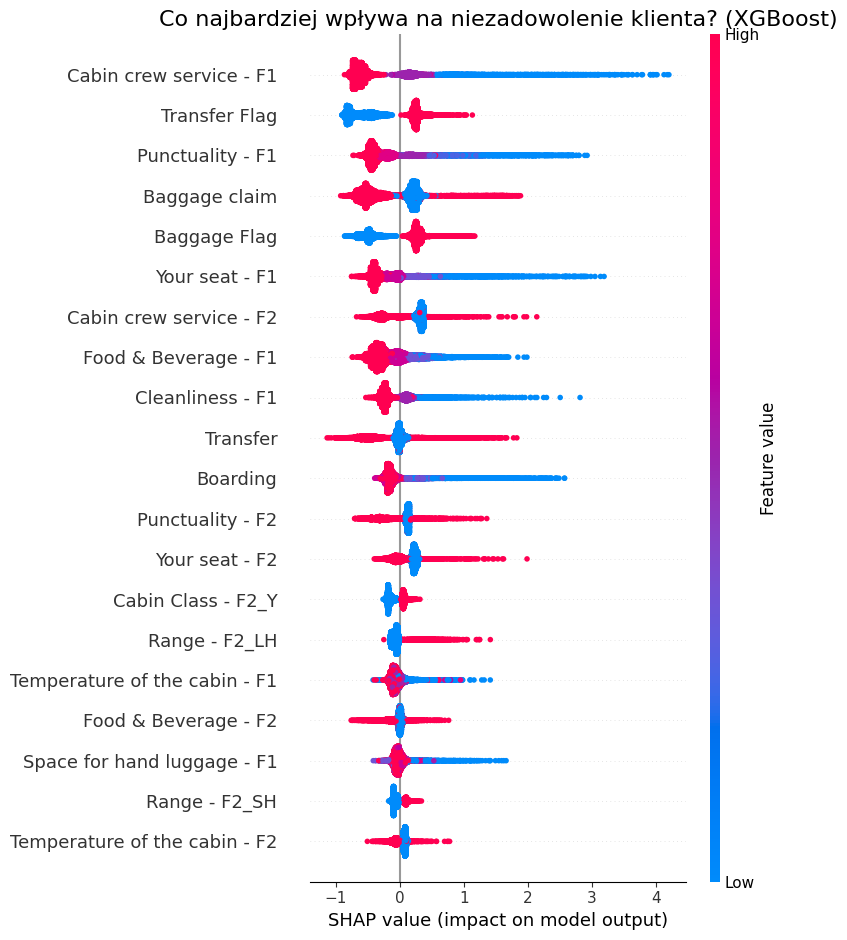

In [100]:
import shap
import matplotlib.pyplot as plt

# 1. Przygotowanie Explainera dla XGBoosta
# TreeExplainer jest dedykowany dla drzew i jest bardzo szybki
explainer = shap.TreeExplainer(best_xgb_obj)

# 2. Obliczenie wartości SHAP dla zbioru TESTOWEGO
# (Liczymy to na danych, których model nie widział podczas treningu)
shap_values = explainer.shap_values(X_test_tree_final)

# 3. Rysowanie wykresu Summary Plot (Najważniejszy wykres!)
print("Generowanie wykresu wpływu cech (Global Feature Importance)...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_tree_final, show=False)

# Dodatkowe ustawienia dla czytelności (opcjonalne)
plt.title("Co najbardziej wpływa na niezadowolenie klienta? (XGBoost)", fontsize=16)
plt.tight_layout()
plt.show()

# Pozostałe

### 1.2 Poboczne statystyki i wizualizacje

In [28]:
#Sprawdzam z jakiego czasu mamy dane ankietowe
df['Response Date'] = df['Response Date'].str[:10]
df['Response Date'] = pd.to_datetime(df['Response Date'], format='%d.%m.%Y')
print(df['Response Date'].head())

0   2025-12-15
1   2025-12-15
2   2025-12-16
3   2025-12-15
4   2025-12-15
Name: Response Date, dtype: datetime64[ns]


In [29]:
df['Response Date'].min() #Pierwsza ankieta wpadła 3 styzcnia 2025

Timestamp('2025-01-03 00:00:00')

In [30]:
df['Response Date'].max() #Ostatnia ankieta wpadła 16 grudnia 2025

Timestamp('2025-12-16 00:00:00')

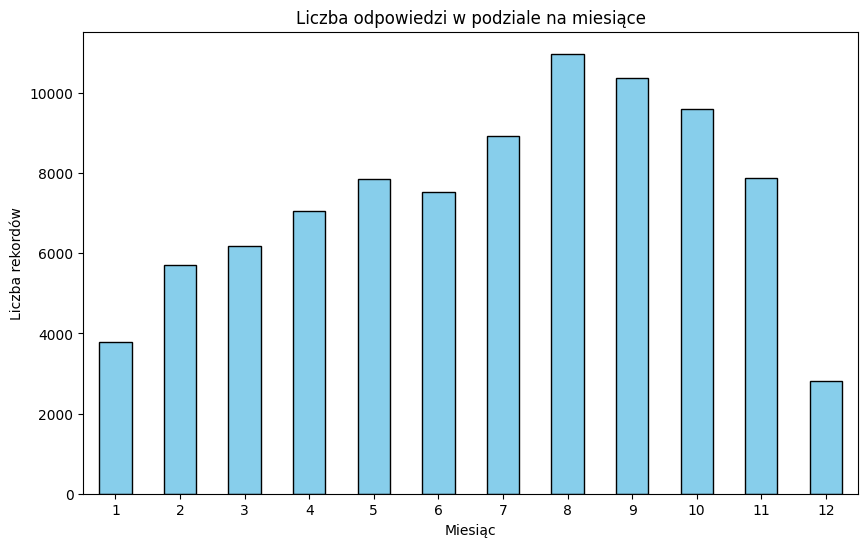

In [31]:
# Wyciągamy miesiąc i liczymy wystąpienia
monthly_data = df['Response Date'].dt.month.value_counts().sort_index()

# Wykres
plt.figure(figsize=(10, 6))
monthly_data.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Liczba odpowiedzi w podziale na miesiące')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba rekordów')
plt.xticks(rotation=0)
plt.show()
#Zauważalnie w grudniu odpowiedzi było najmniej, to oczywiste ponieważ ostatnia ankieta wpadła 16 grudnia 2025

In [32]:
#Sprawdzam jakie mam unikalne kategorie wieku
df['Age'].unique()

array(['50 years old and more', '40-49', '30-39', 'Under 30 years old',
       nan, 'I prefer not to say'], dtype=object)

In [34]:
df.loc[df['Age'].isna(), 'Age'] = "I prefer not to say" #Braki w zmiennej age wynikają z niechęci do zaznaczenia

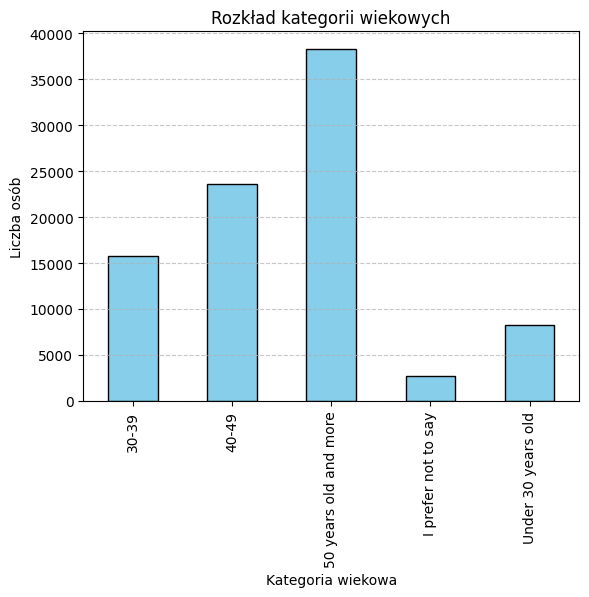

In [35]:
df['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład kategorii wiekowych')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

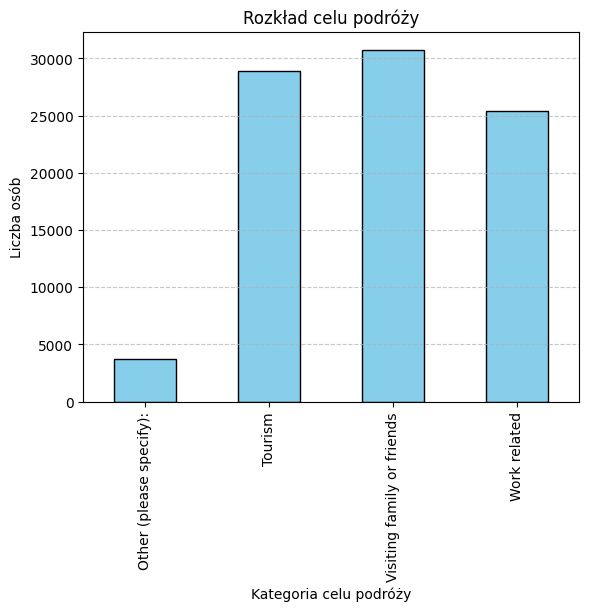

In [16]:
df['Purpose of trip'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład celu podróży')
plt.xlabel('Kategoria celu podróży')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

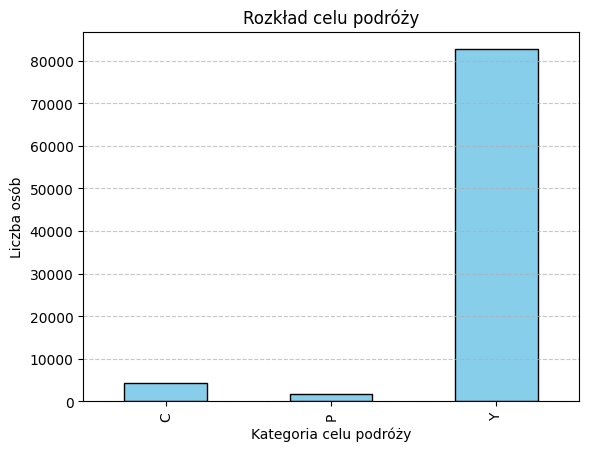

In [17]:
df['Cabin Class - F1'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład klas serwisowych')
plt.xlabel('Klasa serwisowa')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()
#Najmniej jest premium, ponieważ ta klasa nie występuje u tego przewoźnika na trasach Short Haul

### 1.4 Modyfikacja zmiennych

In [ ]:
# Tworzymy zmienną binarną
# NPS <= 8 -> 1 (Niezadowolony)
# NPS > 8  -> 0 (Zadowolony)
df['NPS_bin'] = (df['NPS'] <= 8).astype(int)

# Szybkie sprawdzenie rozkładu
print(df['NPS_bin'].value_counts())